<a href="https://colab.research.google.com/github/rybinsky/Distillation/blob/master/Distill.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [77]:
import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
from IPython.display import clear_output

from math import ceil, sqrt

import torch.nn.functional as F

import numpy as np
import random

import warnings
warnings.filterwarnings("ignore")
# autoreload ALL modules in real time
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [78]:
# Section of setting seeds for reproducible results of training CNNs

# Set the seed for the Python random module
random.seed(0)

# Set the seed for NumPy's random number generator
np.random.seed(1)

# Set the seed for PyTorch's random number generator
torch.manual_seed(2)

# If training on GPU, set the seed for the GPU backend and CUDA library
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(3)

g = torch.Generator()
g.manual_seed(4)

In [79]:
def show_images(images, labels=None, title=None, transform=None, figsize=(12, 12)):
    fig = plt.figure(figsize=figsize, linewidth=5)
    grid_val = ceil(sqrt(len(images)))
    grid_specs = plt.GridSpec(grid_val, grid_val)
    
    for i, image in enumerate(images):
        ax = fig.add_subplot(grid_specs[i // grid_val, i % grid_val])
        ax.axis('off')
        
        if transform is not None:
            image = transform(image)
        
        if labels is not None:
            ax_title = labels[i]
        else:
            ax_title = '#{}'.format(i+1)
            
        ax.set_title(ax_title)
        ax.imshow(image, cmap='gray')
            
    if title:
        fig.suptitle(title, y=0.93, fontsize='xx-large')
    plt.show()

In [80]:
num_workers = 4     # maximum number of subprocces (check https://pytorch.org/docs/stable/data.html for more info)
batch_size = 64


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using {} device'.format(device))

Using cuda device


## Load [MNIST](https://en.wikipedia.org/wiki/MNIST_database) dataset from torchvision.datasets:

In [81]:
transform = transforms.Compose([
    transforms.ToTensor()
])

# download data
train_data = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, 
    transform=transform
)

test_data = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, 
    transform=transform
)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


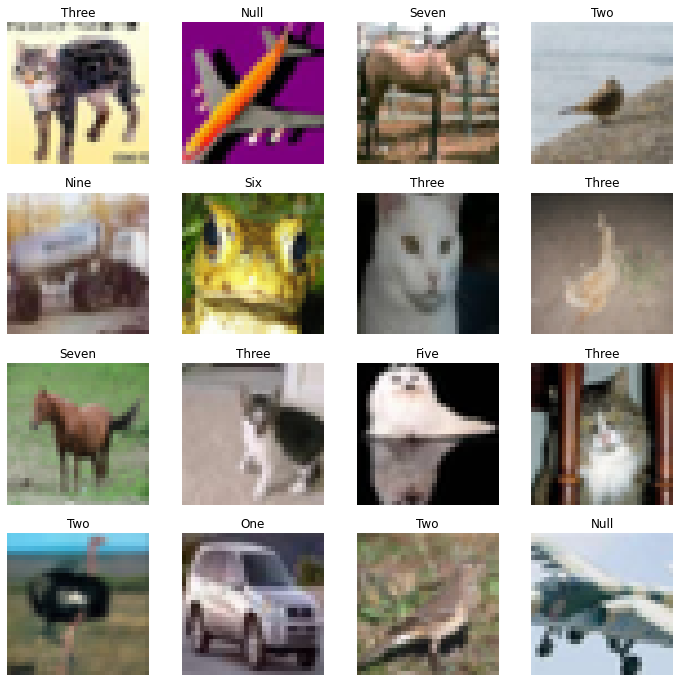

In [82]:
# create dataloaders for model
train_dataloader = torch.utils.data.DataLoader(
    train_data, shuffle=True, 
    batch_size=batch_size, num_workers=num_workers, generator=g
)

test_dataloader = torch.utils.data.DataLoader(
    test_data, shuffle=True, 
    batch_size=batch_size, num_workers=num_workers, generator=g
)

# show some images from MNIST
labels_map = {
    0: "Null",
    1: "One",
    2: "Two",
    3: "Three",
    4: "Four",
    5: "Five",
    6: "Six",
    7: "Seven",
    8: "Eight",
    9: "Nine",
}

N_samples = 16
images, labels = next(iter(train_dataloader))
show_images(
    images[:N_samples], 
    [labels_map[i.item()] for i in labels[:N_samples]], 
    transform=transforms.ToPILImage()
);

In [83]:
## Train-test loops

## Train-test loops

In [84]:
import IPython
from math import ceil


def train_loop(model, dataloader, loss_fn, optimizer, step=0.05, history_loss=None, history_acc=None):
    out = display(IPython.display.Pretty('Learning...'), display_id=True)

    size = len(dataloader.dataset) 
    len_size = len(str(size))
    batches = ceil(size / dataloader.batch_size) - 1
    
    train_acc, train_loss = [], []
    percentage = 0
    
    for batch, (X, y) in enumerate(tqdm(dataloader, leave=False, desc="Batch #")):
        X, y = X.to(device), y.to(device)

        # forward pass
        y_pred = model(X)
        loss = loss_fn(y_pred, y)

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # update statistics
        train_loss.append(loss.item())
        train_acc.append((y_pred.argmax(1) == y).sum().item() / len(X))
                
        # print info
        if batch / batches > percentage or batch == batches: 
            out.update(f'[{int(percentage * size)}/{size}] Loss: {loss:>8f}')
            percentage += step
        
    if history_loss is not None:
        history_loss.append(np.mean(train_loss))
    if history_acc is not None:
        history_acc.append(np.mean(train_acc))

    return {'train_loss': np.mean(train_loss), 'train_acc': np.mean(train_acc)}

def test_loop(model, dataloader, loss_fn, history_loss=None, history_acc=None):

    size = len(dataloader.dataset)
    test_loss, correct = 0, 0
    batches = ceil(size / dataloader.batch_size)

    val_loss, val_acc = [], []
    
    with torch.no_grad():
        for X, y in tqdm(dataloader, leave=False, desc="Batch #"):
            X, y = X.to(device), y.to(device)

            # evaluate
            y_pred = model(X)
            loss = loss_fn(y_pred, y)

            # check predictions
            test_loss += loss.item()
            correct += (y_pred.argmax(1) == y).sum().item()

            # update statistics
            val_loss.append(loss.item())
            val_acc.append((y_pred.argmax(1) == y).sum().item() / len(X))

    test_loss /= batches
    correct /= size
    
    print(f"Validation accuracy: {(100*correct):>0.1f}%, Validation loss: {test_loss:>8f} \n")

    if history_loss is not None:
        history_loss.append(np.mean(val_loss))
    if history_acc is not None:
        history_acc.append(np.mean(val_acc))
    
    return {'val_loss': np.mean(val_loss), 'val_acc': np.mean(val_acc)}


In [85]:
def distil_train_loop(large_model, distil_model, dataloader, loss_fn, optimizer, step=0.05, history_loss=None, history_acc=None):
    out = display(IPython.display.Pretty('Learning...'), display_id=True)

    size = len(dataloader.dataset) 
    len_size = len(str(size))
    batches = ceil(size / dataloader.batch_size) - 1
    
    train_acc, train_loss = [], []
    percentage = 0

    large_model.eval()
    distil_model.train()

    for batch, (X, y) in enumerate(tqdm(dataloader, leave=False, desc="Batch #")):
        X, y = X.to(device), y.to(device)

        # forward pass

        # backward pass
        optimizer.zero_grad()

        soft_label = F.softmax(large_model(X)/temp)

        y_pred = distil_model(X)

        soft_out = F.softmax(y_pred/temp)  

        loss = (1 - distil_weight) * F.cross_entropy(y_pred, y) + (distil_weight) * loss_fn(soft_label,soft_out)
        loss.backward()
        optimizer.step()
        
        # update statistics
        train_loss.append(loss.item())
        train_acc.append((y_pred.argmax(1) == y).sum().item() / len(X))
                
        # print info
        if batch / batches > percentage or batch == batches: 
            out.update(f'[{int(percentage * size)}/{size}] Loss: {loss:>8f}')
            percentage += step
        
    if history_loss is not None:
        history_loss.append(np.mean(train_loss))
    if history_acc is not None:
        history_acc.append(np.mean(train_acc))

    return {'train_loss': np.mean(train_loss), 'train_acc': np.mean(train_acc)}



In [86]:
def plot_learning_process(train_loss, train_acc, val_loss, val_acc):
    
    fig = plt.figure(figsize=(12, 4))
    
    ax1 = plt.subplot(121)
    ax1.set_title('loss by epoch')
    ax1.plot(np.arange(0, len(train_loss)) + 0.5, train_loss, label='train')
    ax1.plot(np.arange(0, len(val_loss)) + 1, val_loss, label='val')
    ax1.legend()
    ax1.grid()
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('loss function')

    ax2 = plt.subplot(122)
    ax2.set_title('accuracy by epoch')
    ax2.plot(np.arange(0, len(train_acc)) + 0.5, train_acc, label='train')
    ax2.plot(np.arange(0, len(val_acc)) + 1, val_acc, label='val')
    ax2.legend()
    ax2.grid()
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('accuracy')
    
    fig.tight_layout()
    plt.show()

#Models

In [87]:
import torch
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        stride = (2, 2) if in_channels != out_channels else (1, 1)
        
        self.shortcut = nn.Identity() if in_channels == out_channels else nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False)
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.activation = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
    def forward(self, x):
        residual = self.shortcut(x)
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.activation(x)
        x = self.conv2(x)
        x = self.bn2(x)
        
        return x + residual
        
class ResNetLayer(nn.Module):
    '''
    This class should be implemented similarly to layer from the pytorch implementation.

    To implement the layer, you will need to create two ResidualBlocks inside.
    Determining the appropriate dimensions is up to you.
    '''

    def __init__(self, in_channels, out_channels):
        '''
        The layer must have the following field declared:
            *self.blocks
        '''

        super().__init__()

        self.blocks = nn.Sequential(
            ResidualBlock(in_channels, out_channels),
            ResidualBlock(out_channels, out_channels)
        )

    def forward(self, x):
        '''
        Note that blocks must be packed to make forward work in its original form.
        '''
        x = self.blocks(x)
        return x

class ResNet18(nn.Module):
     '''
     Finally, this class should consist of three main components:
       1. Four preparatory layers
       2. A set of internal ResNetLayers
       3. Final classifier

     Hint! In order for the network to process images from CIFAR10, you should replace the parameters
           of the first convolutional layer on kernel_size=(3, 3), stride=(1, 1) and padding=(1, 1).
     '''

     def __init__(self, in_channels=3, n_classes=10):
         '''
         The class must have the following fields declared:
             *self.conv1
             *self.bn1
             *self.activation
             *self.maxpool
             *self.layers
             *self.avgpool
             *self.flatten
             *self.fc

         A different grouping of parameters is allowed that does not violate the idea of the network architecture.
         '''

         super().__init__()

         self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=1, padding=1, bias=False)
         self.bn1 = nn.BatchNorm2d(64)
         self.activation = nn.ReLU(inplace=True)
         self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

         self.layer1 = ResNetLayer(64, 64)
         self.layer2 = ResNetLayer(64, 128)
         self.layer3 = ResNetLayer(128, 256)
         self.layer4 = ResNetLayer(256, 512)

         self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
         self.flatten = nn.Flatten()
         self.fc = nn.Linear(512, n_classes)

     def forward(self, x):

         x = self.conv1(x)
         x = self.bn1(x)
         x = self.activation(x)
         x = self.maxpool(x)

         x = self.layer1(x)
         x = self.layer2(x)
         x = self.layer3(x)
         x = self.layer4(x)

         x = self.avgpool(x)
         x = self.flatten(x)
         x = self.fc(x)

         return x

In [88]:
import torch
import torch.nn as nn


class ResidualBlock50(nn.Module):
     
     def __init__(self, in_channels, out_channels, stride=1):
         super(ResidualBlock50, self).__init__()
         self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
         self.bn1 = nn.BatchNorm2d(out_channels)
         self.relu = nn.ReLU(inplace=True)
         self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
         self.bn2 = nn.BatchNorm2d(out_channels)
         self.shortcut = nn.Sequential()
         if stride != 1 or in_channels != out_channels:
             self.shortcut = nn.Sequential(
                 nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                 nn.BatchNorm2d(out_channels)
             )

     def forward(self, x):
         residual = self.shortcut(x)
         
         x = self.conv1(x)
         x = self.bn1(x)
         x = self.relu(x)
         x = self.conv2(x)
         x = self.bn2(x)
         x += residual
         x = self.relu(x)

         return x


class ResNetLayer50(nn.Module):
     
     def __init__(self, in_channels, out_channels, n_blocks, stride=1):
         super(ResNetLayer50, self).__init__()
         self.blocks = nn.Sequential()
         self.blocks.add_module("block0", ResidualBlock50(in_channels, out_channels, stride=stride))
         for block_idx in range(1, n_blocks):
             self.blocks.add_module(f"block{block_idx}", ResidualBlock50(out_channels, out_channels))

     def forward(self, x):
         x = self.blocks(x)
         return x


class ResNet50(nn.Module):
     
     def __init__(self, in_channels=3, n_classes=10):
         super(ResNet50, self).__init__()
         self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1, bias=False)
         self.bn1 = nn.BatchNorm2d(64)
         self.relu = nn.ReLU(inplace=True)
         self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

         self.layer1 = ResNetLayer50(in_channels=64, out_channels=64, n_blocks=3)
         self.layer2 = ResNetLayer50(in_channels=64, out_channels=128, n_blocks=4, stride=2)
         self.layer3 = ResNetLayer50(in_channels=128, out_channels=256, n_blocks=6, stride=2)
         self.layer4 = ResNetLayer50(in_channels=256, out_channels=512, n_blocks=3, stride=2)

         self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
         self.flatten = nn.Flatten()
         self.fc = nn.Linear(512, n_classes)

     def forward(self, x):
         x = self.conv1(x)
         x = self.bn1(x)
         x = self.relu(x)
         x = self.maxpool(x)

         x = self.layer1(x)
         x = self.layer2(x)
         x = self.layer3(x)
         x = self.layer4(x)

         x = self.avgpool(x)
         x = self.flatten(x)
         x = self.fc(x)

         return x

In [89]:
#torchvision.models.resnet18() # uncomment this to see a Hint 0!
#ResNet18()

## Train large model

In [93]:
model = ResNet50(in_channels = 3)

In [94]:
if torch.cuda.is_available():
    model.cuda()

In [95]:
# loss_fn, optimizer and number of epochs are required
loss_fn_teacher = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Define the number of epochs
epochs = 8

train_loss, train_acc = [], []
val_loss, val_acc = [], []
# Train the model
for epoch in tqdm(range(epochs)):
    print(f"Epoch {epoch+1}\n-------------------------------")
    # training loop
    train_results = train_loop(model, train_dataloader, loss_fn_teacher, optimizer)
    train_loss.append(train_results['train_loss'])
    train_acc.append(train_results['train_acc'])
    print(f"Train loss: {train_loss[-1]:.4f}, Train accuracy: {train_acc[-1]*100:.2f}%")

    # validation loop
    val_results = test_loop(model, test_dataloader, loss_fn_teacher)
    val_loss.append(val_results['val_loss'])
    val_acc.append(val_results['val_acc'])
    print(f"Validation loss: {val_loss[-1]:.4f}, Validation accuracy: {val_acc[-1]*100:.2f}%\n")

print("Finished Training")


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 1
-------------------------------


'[50000/50000] Loss: 1.051784'

Batch #:   0%|          | 0/782 [00:00<?, ?it/s]

Train loss: 1.3544, Train accuracy: 50.75%


Batch #:   0%|          | 0/157 [00:00<?, ?it/s]

Validation accuracy: 60.8%, Validation loss: 1.107545 

Validation loss: 1.1075, Validation accuracy: 60.78%

Epoch 2
-------------------------------


'[50000/50000] Loss: 1.788056'

Batch #:   0%|          | 0/782 [00:00<?, ?it/s]

Train loss: 0.9102, Train accuracy: 67.81%


Batch #:   0%|          | 0/157 [00:00<?, ?it/s]

Validation accuracy: 69.3%, Validation loss: 0.877516 

Validation loss: 0.8775, Validation accuracy: 69.28%

Epoch 3
-------------------------------


'[50000/50000] Loss: 0.757493'

Batch #:   0%|          | 0/782 [00:00<?, ?it/s]

Train loss: 0.6858, Train accuracy: 75.95%


Batch #:   0%|          | 0/157 [00:00<?, ?it/s]

Validation accuracy: 73.2%, Validation loss: 0.777403 

Validation loss: 0.7774, Validation accuracy: 73.27%

Epoch 4
-------------------------------


'[50000/50000] Loss: 0.872910'

Batch #:   0%|          | 0/782 [00:00<?, ?it/s]

Train loss: 0.5310, Train accuracy: 81.53%


Batch #:   0%|          | 0/157 [00:00<?, ?it/s]

Validation accuracy: 73.7%, Validation loss: 0.787496 

Validation loss: 0.7875, Validation accuracy: 73.72%

Epoch 5
-------------------------------


'[50000/50000] Loss: 1.339584'

Batch #:   0%|          | 0/782 [00:00<?, ?it/s]

Train loss: 0.4084, Train accuracy: 85.57%


Batch #:   0%|          | 0/157 [00:00<?, ?it/s]

Validation accuracy: 74.0%, Validation loss: 0.830344 

Validation loss: 0.8303, Validation accuracy: 73.90%

Epoch 6
-------------------------------


'[50000/50000] Loss: 0.124871'

Batch #:   0%|          | 0/782 [00:00<?, ?it/s]

Train loss: 0.3046, Train accuracy: 89.37%


Batch #:   0%|          | 0/157 [00:00<?, ?it/s]

Validation accuracy: 75.1%, Validation loss: 0.833841 

Validation loss: 0.8338, Validation accuracy: 75.05%

Epoch 7
-------------------------------


'[50000/50000] Loss: 0.771648'

Batch #:   0%|          | 0/782 [00:00<?, ?it/s]

Train loss: 0.2254, Train accuracy: 92.08%


Batch #:   0%|          | 0/157 [00:00<?, ?it/s]

Validation accuracy: 74.7%, Validation loss: 0.906859 

Validation loss: 0.9069, Validation accuracy: 74.69%

Epoch 8
-------------------------------


'[50000/50000] Loss: 0.273875'

Batch #:   0%|          | 0/782 [00:00<?, ?it/s]

Train loss: 0.1752, Train accuracy: 93.96%


Batch #:   0%|          | 0/157 [00:00<?, ?it/s]

Validation accuracy: 75.2%, Validation loss: 0.928823 

Validation loss: 0.9288, Validation accuracy: 75.14%

Finished Training


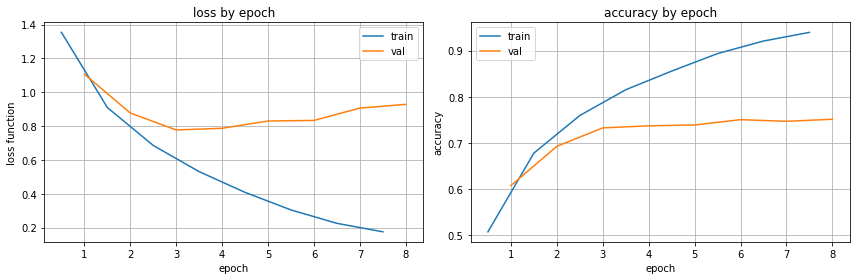

In [96]:
plot_learning_process(train_loss, train_acc, val_loss, val_acc)

In [97]:
distil_model = ResNet18(in_channels = 3)

if torch.cuda.is_available():
    distil_model.cuda()

In [98]:
loss_fn = nn.MSELoss()
distil_weight = 0.7
temp = 20

In [99]:
optimizer = torch.optim.SGD(distil_model.parameters(), lr=0.001, momentum=0.9)

# Define the number of epochs
epochs = 8

train_loss, train_acc = [], []
val_loss, val_acc = [], []
# Train the model
for epoch in tqdm(range(epochs)):
    print(f"Epoch {epoch+1}\n-------------------------------")
    # training loop
    train_results = distil_train_loop(model, distil_model, train_dataloader, loss_fn, optimizer)
    train_loss.append(train_results['train_loss'])
    train_acc.append(train_results['train_acc'])
    print(f"Train loss: {train_loss[-1]:.4f}, Train accuracy: {train_acc[-1]*100:.2f}%")

    # validation loop
    val_results = test_loop(model, test_dataloader, loss_fn_teacher)
    val_loss.append(val_results['val_loss'])
    val_acc.append(val_results['val_acc'])
    print(f"Validation loss: {val_loss[-1]:.4f}, Validation accuracy: {val_acc[-1]*100:.2f}%\n")

print("Finished Training")

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 1
-------------------------------


'[50000/50000] Loss: 0.174045'

Batch #:   0%|          | 0/782 [00:00<?, ?it/s]

Train loss: 0.4017, Train accuracy: 51.99%


Batch #:   0%|          | 0/157 [00:00<?, ?it/s]

Validation accuracy: 76.4%, Validation loss: 0.879506 

Validation loss: 0.8795, Validation accuracy: 76.47%

Epoch 2
-------------------------------


'[50000/50000] Loss: 0.248781'

Batch #:   0%|          | 0/782 [00:00<?, ?it/s]

Train loss: 0.2812, Train accuracy: 66.95%


Batch #:   0%|          | 0/157 [00:00<?, ?it/s]

Validation accuracy: 76.4%, Validation loss: 0.881580 

Validation loss: 0.8816, Validation accuracy: 76.44%

Epoch 3
-------------------------------


'[50000/50000] Loss: 0.384484'

Batch #:   0%|          | 0/782 [00:00<?, ?it/s]

Train loss: 0.2179, Train accuracy: 74.76%


Batch #:   0%|          | 0/157 [00:00<?, ?it/s]

Validation accuracy: 76.4%, Validation loss: 0.887165 

Validation loss: 0.8872, Validation accuracy: 76.32%

Epoch 4
-------------------------------


'[50000/50000] Loss: 0.278691'

Batch #:   0%|          | 0/782 [00:00<?, ?it/s]

Train loss: 0.1645, Train accuracy: 81.19%


Batch #:   0%|          | 0/157 [00:00<?, ?it/s]

Validation accuracy: 76.4%, Validation loss: 0.880780 

Validation loss: 0.8808, Validation accuracy: 76.41%

Epoch 5
-------------------------------


'[50000/50000] Loss: 0.245919'

Batch #:   0%|          | 0/782 [00:00<?, ?it/s]

Train loss: 0.1194, Train accuracy: 86.54%


Batch #:   0%|          | 0/157 [00:00<?, ?it/s]

Validation accuracy: 76.4%, Validation loss: 0.886952 

Validation loss: 0.8870, Validation accuracy: 76.32%

Epoch 6
-------------------------------


'[50000/50000] Loss: 0.063488'

Batch #:   0%|          | 0/782 [00:00<?, ?it/s]

Train loss: 0.0764, Train accuracy: 91.62%


Batch #:   0%|          | 0/157 [00:00<?, ?it/s]

Validation accuracy: 76.4%, Validation loss: 0.884402 

Validation loss: 0.8844, Validation accuracy: 76.41%

Epoch 7
-------------------------------


'[50000/50000] Loss: 0.047841'

Batch #:   0%|          | 0/782 [00:00<?, ?it/s]

Train loss: 0.0456, Train accuracy: 95.34%


Batch #:   0%|          | 0/157 [00:00<?, ?it/s]

Validation accuracy: 76.4%, Validation loss: 0.879593 

Validation loss: 0.8796, Validation accuracy: 76.44%

Epoch 8
-------------------------------


'[50000/50000] Loss: 0.030672'

Batch #:   0%|          | 0/782 [00:00<?, ?it/s]

Train loss: 0.0280, Train accuracy: 97.35%


Batch #:   0%|          | 0/157 [00:00<?, ?it/s]

Validation accuracy: 76.4%, Validation loss: 0.879708 

Validation loss: 0.8797, Validation accuracy: 76.47%

Finished Training


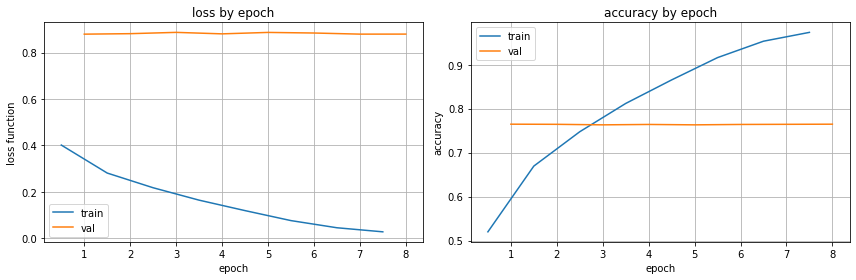

In [100]:
plot_learning_process(train_loss, train_acc, val_loss, val_acc)